In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from google.colab import drive

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

# **1. Dataset**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ds = pd.read_csv('/content/drive/MyDrive/colab-notebooks/predicting-house-prices/dataset/housing.csv')
ds # ds.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
ds.shape  # Dataframe 2D

(20640, 10)

In [5]:
ds[["total_rooms", "median_house_value"]] # Dataframe 2D

,total_rooms,median_house_value
0,880.0,452600.0
1,7099.0,358500.0
2,1467.0,352100.0
3,1274.0,341300.0
4,1627.0,342200.0
...,...,...
20635,1665.0,78100.0
20636,697.0,77100.0
20637,2254.0,92300.0
20638,1860.0,84700.0


In [6]:
ds["median_house_value"] # series 1D

,median_house_value
0,452600.0
1,358500.0
2,352100.0
3,341300.0
4,342200.0
...,...
20635,78100.0
20636,77100.0
20637,92300.0
20638,84700.0


In [7]:
ds["median_house_value"][0]

np.float64(452600.0)

In [8]:
ds.isnull().sum()   # check null

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [9]:
ds.info() # check kiểu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
for col in ds.columns:
    print(ds[col].map(type).value_counts(), '\n')
    print("=====================================")

longitude
<class 'float'>    20640
Name: count, dtype: int64 

latitude
<class 'float'>    20640
Name: count, dtype: int64 

housing_median_age
<class 'float'>    20640
Name: count, dtype: int64 

total_rooms
<class 'float'>    20640
Name: count, dtype: int64 

total_bedrooms
<class 'float'>    20640
Name: count, dtype: int64 

population
<class 'float'>    20640
Name: count, dtype: int64 

households
<class 'float'>    20640
Name: count, dtype: int64 

median_income
<class 'float'>    20640
Name: count, dtype: int64 

median_house_value
<class 'float'>    20640
Name: count, dtype: int64 

ocean_proximity
<class 'str'>    20640
Name: count, dtype: int64 



# **#. String-columns**

In [11]:
for col in ['ocean_proximity']:
  ds[col] = ds[col].apply(
    lambda val: str(val).strip().lower() if pd.notnull(val) and (str(val).strip().lower() not in ["null", "nan", "n/a", "none"])
    else ""
  )

  # mode
  mode_vals = ds.loc[ds[col] != "", col].mode()
  if not mode_vals.empty:
      ds[col] = ds[col].replace("", mode_vals[0])

In [12]:
ds['ocean_proximity'].value_counts() # xác định encoder

,count
ocean_proximity,
<1h ocean,9136
inland,6551
near ocean,2658
near bay,2290
island,5


In [13]:
ocp_encoder = OneHotEncoder(sparse_output=False) # encode nhị phân

ocp_encoded = ocp_encoder.fit_transform(np.array(ds[['ocean_proximity']])) # fit và transform, array

ocp_encoded_df = pd.DataFrame(ocp_encoded, columns=ocp_encoder.get_feature_names_out(['ocean_proximity'])) # tạo dataframe

ds = pd.concat([ds.drop('ocean_proximity', axis=1), ocp_encoded_df], axis=1) # nối dataframe

# ds[onehot_encoder.get_feature_names_out(['col_name'])] = onehot_encoder.fit_transform(np.array(ds[['col_name']]))
# ds = ds.drop(columns=['col_name'])

In [14]:
ds.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1h ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near bay,ocean_proximity_near ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


# **#. Number-columns**

In [15]:
for col in ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]:
  ds[col] = pd.to_numeric(ds[col], errors='coerce') # invalid thành NaN
  ds[col] = ds[col].fillna(ds[col].median()) # trung vị

# **#. Spit dataset**

In [16]:
Y = ds[["median_house_value"]]
Y.head()

,median_house_value
0,452600.0
1,358500.0
2,352100.0
3,341300.0
4,342200.0


In [17]:
Y.shape # df 2D: (row, column)

(20640, 1)

In [18]:
X = ds.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1h ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near bay,ocean_proximity_near ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0.0,0.0,0.0,1.0,0.0


In [19]:
X.shape  # df 2D: (row, column)

(20640, 13)

In [20]:
X_train, X_remain, Y_train, Y_remain = train_test_split(X, Y, test_size=0.15, random_state=123)

In [21]:
remain_length = len(X_remain)
test_length = math.floor(len(X)*0.05)
test_ratio_in_remain = test_length/remain_length

In [22]:
X_val, X_test, Y_val, Y_test = train_test_split(X_remain, Y_remain, test_size=test_ratio_in_remain, random_state=123)

In [23]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

Y_train = Y_train.reset_index(drop=True)
Y_val = Y_val.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

# **#. Scale**
-chỉ scale sau khi đã encode và split

-chia tỉ lệ về [0, 1]

In [24]:
X_scaler = MinMaxScaler() # tính min, max trong từng cột
Y_scaler = MinMaxScaler()

# 2D
X_train = X_scaler.fit_transform(np.array(X_train))  # fit và transform, array
X_val = X_scaler.transform(np.array(X_val))     # transform
X_test = X_scaler.transform(np.array(X_test))   # transform

# 2D
Y_train = Y_scaler.fit_transform(np.array(Y_train))
Y_val = Y_scaler.transform(np.array(Y_val))
Y_test = Y_scaler.transform(np.array(Y_test))

In [25]:
print(f'X_train: \n{X_train[:1]}')
print(f'Y_train: \n{Y_train[:1]}')

X_train: 
[[0.65039841 0.12646121 0.45098039 0.02144056 0.02932961 0.01676995
  0.03108041 0.28992704 1.         0.         0.         0.
  0.        ]]
Y_train: 
[[0.43298997]]


# **2. Model**

In [26]:
#kiến trúc model

model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

# output-layer: 1 neuron, không activation (vì hồi quy)
model.add(Dense(1))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 45,697 (178.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [27]:
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=500,
                    batch_size=250,
                    callbacks=[early_stop], verbose=1)

Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.1920 - mae: 0.3220 - val_loss: 0.0769 - val_mae: 0.1915
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388 - mae: 0.1500 - val_loss: 0.0484 - val_mae: 0.1651
Epoch 3/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 - mae: 0.1314 - val_loss: 0.0404 - val_mae: 0.1592
Epoch 4/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279 - mae: 0.1246 - val_loss: 0.0403 - val_mae: 0.1524
Epoch 5/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259 - mae: 0.1195 - val_loss: 0.0326 - val_mae: 0.1350
Epoch 6/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - mae: 0.1142 - val_loss: 0.0250 - val_mae: 0.1150
Epoch 7/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - mae: 0.1096 - val_loss: 0.0235 - val_mae: 0.1163
Epoch 8/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - mae: 0.1081 - val_loss: 0.0211 - val_mae: 0.1063
Epoch 9/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.02

# **3. Save model**

In [28]:
import pickle

pickle_dir_path="/content/drive/MyDrive/colab-notebooks/predicting-house-prices/model"

model.save(f"{pickle_dir_path}/model.keras")

with open(f'{pickle_dir_path}/ocp_encoder.pkl', 'wb') as f1:
    pickle.dump(ocp_encoder, f1)

with open(f'{pickle_dir_path}/X_scaler.pkl', 'wb') as f2:
    pickle.dump(X_scaler, f2)

with open(f'{pickle_dir_path}/Y_scaler.pkl', 'wb') as f3:
    pickle.dump(Y_scaler, f3)

# **4. Đánh giá**

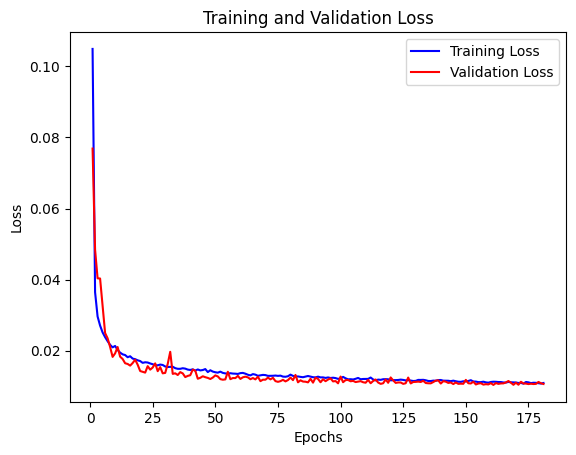

In [29]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

549/549 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


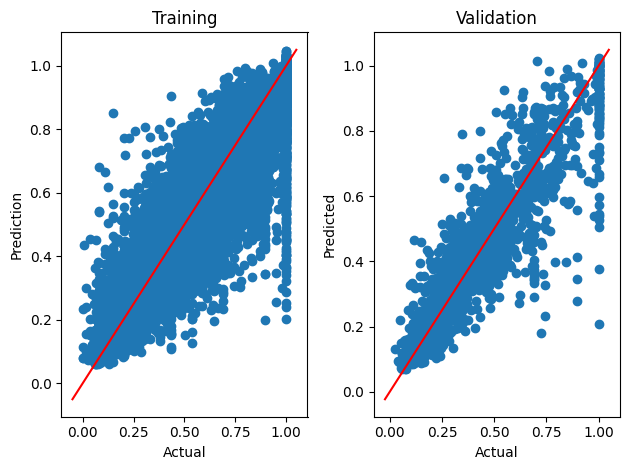

In [30]:
# Specify the dimensions
fig, axes = plt.subplots(1,2)

# This makes the individual subplots
# Training Results
axes[0].scatter(x=Y_train, y=model.predict(X_train))
axes[0].set_xlabel('Actual', fontsize=10)
axes[0].set_ylabel('Prediction', fontsize=10)
axes[0].set_title('Training')

# Add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=Y_val, y=model.predict(X_val))
axes[1].set_xlabel('Actual', fontsize=10)
axes[1].set_ylabel('Predicted', fontsize=10)
axes[1].set_title('Validation')

# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# Tight layout
fig.tight_layout()
plt.show()

In [32]:
# đánh giá model trên tập test
Y_test_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(Y_test, Y_test_pred))
print("MSE:", mean_squared_error(Y_test, Y_test_pred))
print("MSLE:", mean_squared_log_error(Y_test, Y_test_pred))
print("score :", r2_score(Y_test, Y_test_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE: 0.06666546066388415
MSE: 0.009728450278675992
MSLE: 0.004352170054052837
score : 0.8268668330847704


# **5. Dự đoán**

In [ ]:
def prepare_input(longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity):
    # encode
    ocp_encoded = ocp_encoder.transform(np.array([[ocean_proximity.lower()]])) # array(1, 5)

    X_remain = np.array([[longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income]]) # array(1, 8)

    X_predict = np.concatenate((X_remain, ocp_encoded), axis=1)  # array(1, 13)

    # scale
    X_predict = X_scaler.transform(X_predict)

    return X_predict

In [34]:
input = {
    "longitude": -121.22,
    "latitude": 39.43,
    "housing_median_age": 17.0,
    "total_rooms": 2254.0,
    "total_bedrooms": 485.0,
    "population": 1007.0,
    "households": 433.0,
    "median_income": 1.7000,
    "ocean_proximity": "INLAND"
    # "median_house_value": 92300.0
}

X_pred1 = prepare_input(**input)
Y_pred1 = model.predict(X_pred1)
Y_pred1 = Y_scaler.inverse_transform(Y_pred1)
Y_pred1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


array([[100020.69]], dtype=float32)

In [35]:
input = {
    "longitude": -122.25,
    "latitude": 37.85,
    "housing_median_age": 52.0,
    "total_rooms": 1627.0,
    "total_bedrooms": 280.0,
    "population": 565.0,
    "households": 259.0,
    "median_income": 3.8462,
    "ocean_proximity": "NEAR BAY",
    # "median_house_value": 342200.0
}

X_pred2 = prepare_input(**input)
Y_pred2 = model.predict(X_pred2)
Y_pred2 = Y_scaler.inverse_transform(Y_pred2)
Y_pred2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[256034.19]], dtype=float32)

In [36]:
input = {
    "longitude": -122.2300,
    "latitude": 37.8800,
    "housing_median_age": 41.0000,
    "total_rooms": 880.0000,
    "total_bedrooms": 129.0000,
    "population": 322.0000,
    "households": 126.0000,
    "median_income": 8.3252,
    "ocean_proximity": "ISLAND",
    # "median_house_value": 452600.0000
}

X_pred3 = prepare_input(**input)
Y_pred3 = model.predict(X_pred3)
Y_pred3 = Y_scaler.inverse_transform(Y_pred3)
Y_pred3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[316578.]], dtype=float32)

In [37]:
# !pip freeze > /content/drive/MyDrive/colab-notebooks/predicting-house-prices/requirements.txt